# Introduction

Ici je vais écrire la version finale de la méthode EM pour le *cas 3 : Contrainte de pureté*


- [1. Loading of datasets](#Load-datasets)
- [2. Transformation of datasets](#Transform-datasets)
- [3. Helper functions](#Helper-functions)
- [4. Manual EMANN](#Manual-EMANN)
    - [4.1 EM Starts Here !](#EM-Starts-Here-!)
- [5. ReGenerate data](#ReGenerate-data)


[**[Back to top]**](#Introduction)

In [1]:
from __future__ import division, print_function
import sys
if '..' not in sys.path:
    sys.path.append('..')

import theano
import theano.tensor as T
import lasagne

import time
import visual

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix, pairwise_distances

from nn.helper import CNN, NN
from nn import block as nnb
from nn import compilers as nnc


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN 3007)


In [2]:
%matplotlib inline

# Load datasets

- the datasets are loaded/built.
- The batchsize is defined
- half of the data name (the source part) is defined

[**[Back to top]**](#Introduction)

## Datasets Imports 

In [3]:
from datasets.toys import make_clouds, make_circles, make_X, make_moons
from datasets.utils import make_dataset


# Transform datasets

- the transformed datasets are built.
- last part of the data name (the target part) is defined

[**[Back to top]**](#Introduction)

## Transformation Imports

In [4]:
from datasets.utils import make_domain_dataset, make_corrector_dataset
import datasets.transform as transform

# Helper functions

[**[Back to top]**](#Introduction)

In [5]:
# Import loggers
from logs import new_logger, empty_logger
logger = new_logger()

In [6]:
def mass(k_means):
    """
    Params
    ------
        k_means: (sklearn.cluster.KMeans instance)
    Return
    ------
        w: (numpy.array [n_clusters]) the mass of each clusters 
    """
    w = np.unique(k_means.labels_, return_counts=True)[1]
    w = w/np.sum(w)
    return w
    

In [ ]:
from align_learn.preprocess import align

def train_dataset(X_src, X_tgt, k_means_src, k_means_tgt, transp, proba='tgt'):
    """
    
    Params
    ------
        X_src:
        X_tgt:
        k_means_src:
        k_means_tgt:
        transp:
        proba: 'tgt', 'target', 'src', 'source', 'stacked'
        
    Return
    ------
        X:
        Y:
    """
    align_idx, cluster_T = align(transp, k_means_src.labels_, k_means_tgt.labels_)
    X_S, y_S = X_src, y_src
    X_T, y_T = X_tgt[align_idx], y_tgt[align_idx]
    # Build the probabilities to be predict
    # For the source data
    proba_src = np.zeros((X_S.shape[0], k_means_src.n_clusters))
    proba_src[np.arange(X_S.shape[0]), k_means_src.labels_] = 1.
    proba_tgt = transp[k_means_src.labels_]
    proba_tgt = proba_tgt / np.sum(proba_tgt, 1).reshape(-1, 1)
    if proba=='stacked':
        Y_S = np.hstack([proba_src, proba_tgt])
    elif proba=='tgt' or proba=='target':
        Y_S = proba_tgt
    elif proba=='src' or proba=='source':
        Y_S = proba_src
    else:
        raise ValueError("proba option should be 'tgt', 'target', 'src', 'source' or 'stacked'."
                        "{} found".format(proba))

    # Build the probabilities to be predict
    # For the aligned target data
    proba_tgt = np.zeros((X_T.shape[0], k_means_tgt.n_clusters))
    proba_tgt[np.arange(X_T.shape[0]), cluster_T] = 1.
    proba_src = transp[:, cluster_T].T
    proba_src = proba_src / np.sum(proba_src, 1).reshape(-1, 1)
    if proba=='stacked':
        Y_T = np.hstack([proba_src, proba_tgt])
    elif proba=='tgt' or proba=='target':
        Y_T = proba_tgt
    elif proba=='src' or proba=='source':
        Y_T = proba_src
    else:
        raise ValueError("proba option should be 'tgt', 'target', 'src', 'source' or 'stacked'."
                        "{} found".format(proba))
    
    Y = np.vstack([Y_S, Y_T])
    X = np.vstack([X_S, X_T])
    return X, Y

In [146]:
def align(P, y_src, y_tgt):
    """
    Return indexes of the chosen target data.
    then
    >>> X_S, y_S = X_src, y_src
    >>> X_T, y_T = X_tgt[align_idx], y_tgt[align_idx]
    coresponding transport lines and columns = k_means_src.labels_, k_means_tgt.labels_[idx_tgt]

    Params
    ------
        P: the transport/probability matrix
        y_src: the source's data labels
        y_tgt: the target's data labels

    Return
    ------
        align_idx, cluster_T
    """
    labels_src = np.unique(y_src)
    labels_tgt = np.unique(y_tgt)
    src_slices = [np.where(y_src == l_src)[0] for l_src in labels_src]
    tgt_slices = [np.where(y_tgt == l_tgt)[0] for l_tgt in labels_tgt]
    # src member of cluster i go to some tgt cluster j 
    # with the probability in the i-th row of transport matrix
    cluster_choice = [np.random.choice(len(tgt_slices), size=src_idx.shape, p=P[i]/np.sum(P[i])) 
           for i, src_idx in enumerate(src_slices)]
    # Stack it into array. And use the former indexes to match X_src with X_tgt[res]
    cluster_choice_array = np.hstack(cluster_choice)[np.hstack(src_slices)]
    align_idx = np.array([np.random.choice(tgt_slices[i]) for i in cluster_choice_array])
    return align_idx


In [ ]:
align_idx = align(P, y_src, y_tgt)
X_S, y_S = X_src, y_src
X_T, y_T = X_tgt[align_idx], y_tgt[align_idx]

def proba_src_P(P, y_src, y_tgt):
    """
    return the probability of the given 
    """
    # Build the probabilities to be predict
    # For the source data in the source distribution/partition
    n_label = len(np.unique(y_src)[0])
    n_sample = y_src.shape[0]
    proba_src = np.zeros((n_sample, n_label))
    proba_src[np.arange(n_sample), y_src] = 1.
    
    # For the target data in the source distribution/partition
    proba_tgt = P[:, y_tgt].T
    proba_tgt = proba_tgt / np.sum(proba_tgt, 1)[:, np.newaxis]
    
    return proba_src, proba_tgt

def proba_tgt_P(P, y_src, y_tgt):
    """
    return the probability of the given 
    """
    # Build the probabilities to be predict
    # For the target data in the target distribution/partition
    n_label = len(np.unique(y_tgt)[0])
    n_sample = y_tgt.shape[0]
    proba_tgt = np.zeros((n_sample, n_label))
    proba_tgt[np.arange(n_sample), y_tgt] = 1.
    
    # For the source data in the target distribution/partition
    proba_src = P[y_src]
    proba_src = proba_src / np.sum(proba_src, 1)[:, np.newaxis]
    
    return proba_src, proba_tgt

In [21]:
def renorm(M, w_S=None, w_T=None, max_iter=200, epsilon=1e-6, last='line'):
    """
    """
    # init data
    # ---------
    if w_S is None:
        w_S = np.ones(np.shape(M)[0])
    if w_T is None:
        w_T = np.ones(np.shape(M)[1])
    Nini = len(w_S)
    Nfin = len(w_T)
    
    # we assume that no distances are null except those of the diagonal of distances
    u = np.ones(Nini)/Nini
    v = np.ones(Nfin)/Nfin
    uprev = np.zeros(Nini)
    cpt = 0
    err = 1
    # Main loop
    # ---------
    while (err > epsilon and cpt < max_iter):
        cpt = cpt +1
        # First we do a sanity check
        if np.logical_or(np.any(np.dot(M.T,u)==0),np.isnan(np.sum(u))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Infinity')
            if cpt!=0:
                u = uprev
            break
        uprev = u  # Save the previous results in case of divide by 0
        # now the real algo part : update vectors u and v
        v = w_T/np.dot(M.T,u)
        u = w_S/np.dot(M,v)
        # Computing the new error value
        if cpt%10==0:
            # we can speed up the process by checking for the error only all the n-th iterations
            final = u[:, np.newaxis]*M*v[:, np.newaxis].T
            err = np.linalg.norm((np.sum(final, axis=0)-w_T))**2
    # End of Main loop
    # Return the transpotation matrix
    if last=='column':
        v = w_T/np.dot(M.T,u)
    return u[:, np.newaxis]*M*v[:, np.newaxis].T


In [22]:
def softmax_alpha(x, alpha=1.0):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(alpha*(x - np.max(x)))
    return e_x / e_x.sum(1)[:, np.newaxis]

# Manual EMANN

[**[Back to top]**](#Introduction)

In [23]:
EM_ITER = 0

**Generate data**

In [24]:
n_classes_1 = 4
n_classes_2 = 4
n_samples = 1000
X_src, y_src = make_clouds(n_samples=n_samples, n_classes=n_classes_1)

X_tgt, y_tgt = make_clouds(n_samples=n_samples, n_classes=n_classes_1)
# X_tgt, y_tgt = make_circles(n_samples=n_samples,  n_classes=n_classes_2)

data_name='Clouds -> Same'

**Clusters**

In [25]:
from sklearn.cluster import KMeans

k_src = 10
k_tgt = 12
# We do not need to have the same number of cluster in the source and target data.
k_means_src = KMeans(n_clusters=k_src).fit(X_src)
k_means_tgt = KMeans(n_clusters=k_tgt).fit(X_tgt)
# Mass and cost matrix
w_src = mass(k_means_src)
w_tgt = mass(k_means_tgt)

**Random proba matrix**

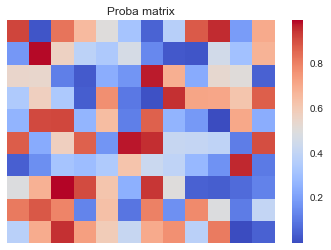

In [26]:
P = np.random.uniform(0,1, size=(w_src.shape[0], w_tgt.shape[0]))
visual.mat(P)
plt.title("Proba matrix")
plt.show()

In [27]:
M = renorm(P, last='column')
print(M.sum(0))
print(M.sum(1))
print('--------')
M = renorm(P, last='line')
print(M.sum(0))
print(M.sum(1))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2]
--------
[ 0.83333333  0.83333333  0.83333333  0.83333333  0.83333333  0.83333333
  0.83333333  0.83333333  0.83333333  0.83333333  0.83333333  0.83333333]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


39.1412158478 1646.40721561


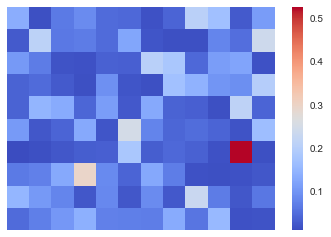

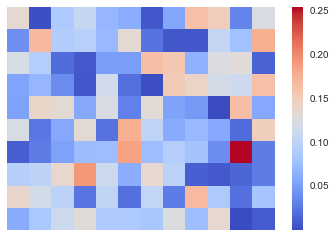

In [28]:
sa = softmax_alpha(M, 15)
print(sa.max()/sa.min(), M.max()/M.min())
visual.mat(sa);
visual.mat(M);


**Dual Proba dataset**

In [93]:
X, Y = train_dataset(X_src, X_tgt, k_means_src, k_means_tgt, P)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X, Y = X[indices], Y[indices]
data = make_dataset(X, Y, batchsize=100)

**Neural Network Architecture**

In [128]:
# Get general information :
# =========================
batchsize = data.batchsize
_shape = np.shape(data.X_train)
n_dim = len(_shape)
n_features = np.prod(_shape[1:])

shape = (batchsize,) + _shape[1:]
target_var = T.ivector('targets')

# Logs
logger.info('Building the input and output variables for : {}'.format(data_name))
logger.info('Input data expected shape : {}'.format(shape))

# WARNING :: Une seule couche de proba. On prédit les ligne pas les colonnes !
# Build the layers :
# ==================
def build(shape):
    input_layer_src = lasagne.layers.InputLayer(shape=shape)

    dense_1 = lasagne.layers.DenseLayer(input_layer, 3, nonlinearity=lasagne.nonlinearities.sigmoid)
    dense_2 = lasagne.layers.DenseLayer(dense_1, shape[1], nonlinearity=lasagne.nonlinearities.sigmoid)

    # With concat :
# WARNING :: Une seule couche de proba. On prédit les ligne pas les colonnes !
#     cluster_src = lasagne.layers.DenseLayer(dense_2, k_src, nonlinearity=lasagne.nonlinearities.softmax)
    cluster_tgt = lasagne.layers.DenseLayer(dense_2, k_tgt, nonlinearity=lasagne.nonlinearities.softmax)
#     concat_layer = lasagne.layers.ConcatLayer([cluster_src, cluster_tgt], axis=1)

    end_layer = cluster_tgt
    return end_layer, dense_2
end_layer, repr_layer = build(shape)

[15:45:12] INFO    : Building the input and output variables for : Clouds -> Same
[15:45:12] INFO    : Input data expected shape : (100, 2)


**Compile the NN**

In [129]:
# Instanciate the NN :
# ====================
# nn = NN(end_layer, name='EMANN test')
nn = CNN(name='EMANN test')
nn.add_output('proba', end_layer)
nn.add_output('repr', repr_layer)

# Compile :
# =========
nn.compile('proba', nnc.crossentropy_sgd_mom, lr=0.1, mom=0.9)
nn.compile('proba', nnc.crossentropy_validation)
nn.compile('proba', nnc.output)
nn.compile('repr', nnc.output)


**Train the NN**

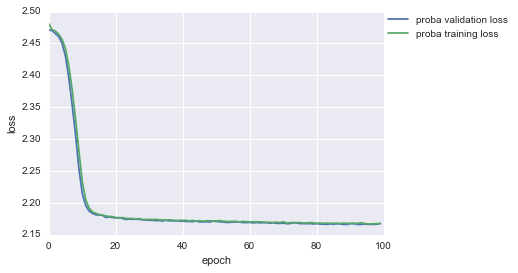

In [130]:
# Train the nn :
# ==============
# nn.train(data, num_epochs=100);
nn.train([data], ['proba'], num_epochs=100);

# ================
# Learning curve
# ================
fig, ax = visual.learning_curve(nn.global_stats, regex='loss')
#     SAVE
# fig.tight_layout()
# fig.savefig(fig_title+'-Learning_curve.png',bbox_inches='tight')
fig.show()

**Check some results**

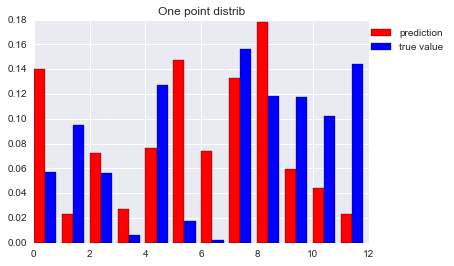

In [131]:
y_pred = nn.parts['proba'].output(data.X_test)[0]
i = np.random.randint(0, data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(k_tgt), y_pred[i], width, color='r', label='prediction')
plt.bar(np.arange(k_tgt)+width, data.y_test[i], width, color='b', label='true value')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.25,1.))
# plt.yscale('log')
plt.show()

## **EM Starts Here !**

[**[Back to top]**](#Introduction)

**Rebuild P**

In [ ]:
# Agregate lines

# softmax_alpha(P)

**Dual Proba dataset**

In [132]:
X, Y = train_dataset(X_src, X_tgt, k_means_src, k_means_tgt, P)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X, Y = X[indices], Y[indices]
data = make_dataset(X, Y, batchsize=100)

**Neural network** (re-initialization)

**Train the NN**

Iteration n* 3


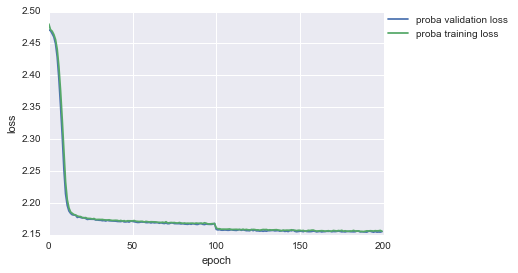

In [133]:
# Train the nn :
# ==============
# nn.train(data, num_epochs=100);
nn.train([data], ['proba'], num_epochs=100);
# ================
# Learning curve
# ================
fig, ax = visual.learning_curve(nn.global_stats, regex='loss')
#     SAVE
# fig.tight_layout()
# fig.savefig(fig_title+'-Learning_curve.png',bbox_inches='tight')
fig.show()

EM_ITER += 1
print('Iteration n*', EM_ITER)

**Check some results**

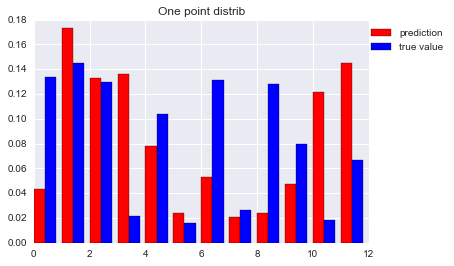

In [144]:
y_pred = nn.parts['proba'].output(data.X_test)[0]
i = np.random.randint(0, data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(k_tgt), y_pred[i], width, color='r', label='prediction')
plt.bar(np.arange(k_tgt)+width, data.y_test[i], width, color='b', label='true value')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.25,1.))
# plt.yscale('log')
plt.show()

[**[EM LOOP]**](#EM-Starts-Here-!)

# ReGenerate data

[**[Back to top]**](#Introduction)

In [145]:
nn.parts['repr'].output(data.X_test)

[array([[ 0.84455299,  0.42574337],
        [ 0.84227717,  0.04779824],
        [ 0.40758595,  0.8933813 ],
        ..., 
        [ 0.1662403 ,  0.03979085],
        [ 0.42333016,  0.00542927],
        [ 0.4279221 ,  0.89302963]], dtype=float32)]